In [48]:
import pandas as pd
import numpy as np
from fbprophet import Prophet
import matplotlib.pyplot as plt
from functools import reduce

plt.style.use('seaborn-deep')
pd.options.display.float_format = '{:,.2f}'.format

In [50]:
#  data preparation
eth_price = pd.read_csv('../ETH_USD_2015-08-09_2021-05-24-CoinDesk.csv', parse_dates=["Date"])
# remove prices from 2017 and before
eth_price = eth_price[(eth_price['Date'].dt.year >= 2017)]
eth_price = eth_price[['Date', 'Closing Price (USD)']]
eth_price.columns = ['ds', 'y']
eth_price.head(10)

,ds,y
1972,2021-01-01,730.04
1973,2021-01-02,771.48
1974,2021-01-03,976.89
1975,2021-01-04,"1,017.86"
1976,2021-01-05,"1,123.16"
1977,2021-01-06,"1,193.57"
1978,2021-01-07,"1,251.05"
1979,2021-01-08,"1,208.58"
1980,2021-01-09,"1,287.48"
1981,2021-01-10,"1,282.00"


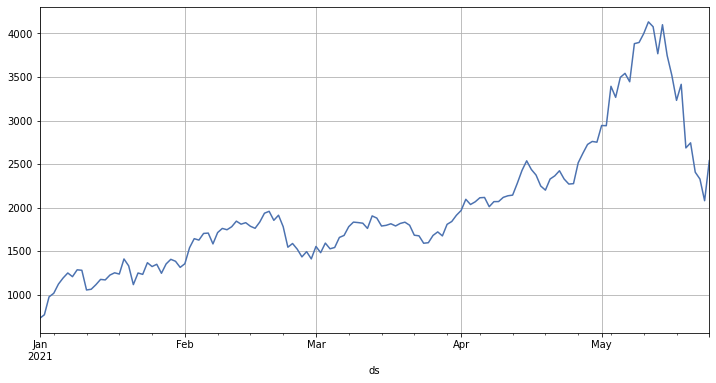

In [52]:
eth_price.set_index('ds').y.plot(figsize=(12,6), grid=True)

In [54]:
model = Prophet()
model.fit(eth_price)

future = model.make_future_dataframe(1095, freq='d')

forecast =  model.predict(future)
forecast.tail()

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
1234,2024-05-19,"29,426.67","20,951.42","37,273.83","21,096.06","37,357.75",-47.03,-47.03,-47.03,-47.03,-47.03,-47.03,0.00,0.00,0.00,"29,379.64"
1235,2024-05-20,"29,450.57","21,039.72","37,312.39","21,099.36","37,395.24",-20.11,-20.11,-20.11,-20.11,-20.11,-20.11,0.00,0.00,0.00,"29,430.46"
1236,2024-05-21,"29,474.46","21,102.54","37,468.02","21,103.29","37,432.74",48.73,48.73,48.73,48.73,48.73,48.73,0.00,0.00,0.00,"29,523.20"
1237,2024-05-22,"29,498.36","21,100.76","37,423.67","21,118.51","37,470.24",26.23,26.23,26.23,26.23,26.23,26.23,0.00,0.00,0.00,"29,524.59"
1238,2024-05-23,"29,522.25","21,191.39","37,495.66","21,137.44","37,507.74",13.92,13.92,13.92,13.92,13.92,13.92,0.00,0.00,0.00,"29,536.17"


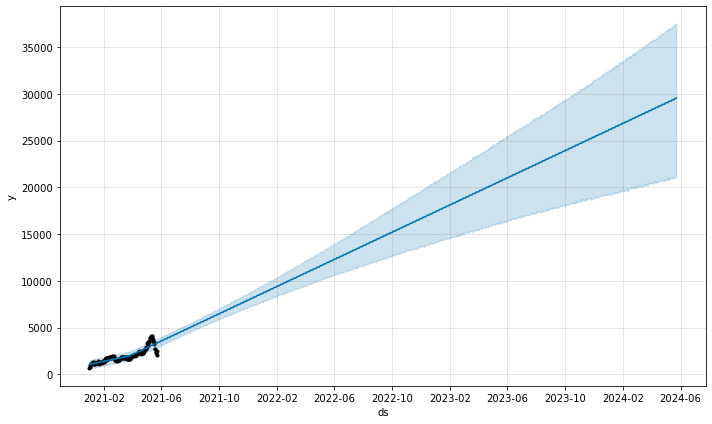

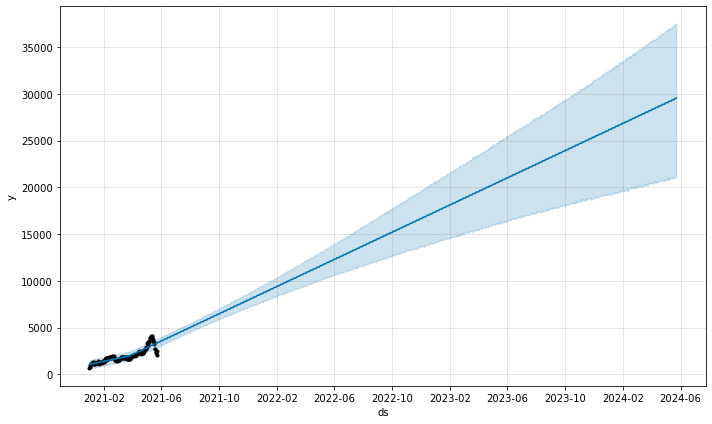

In [56]:
model.plot(forecast)

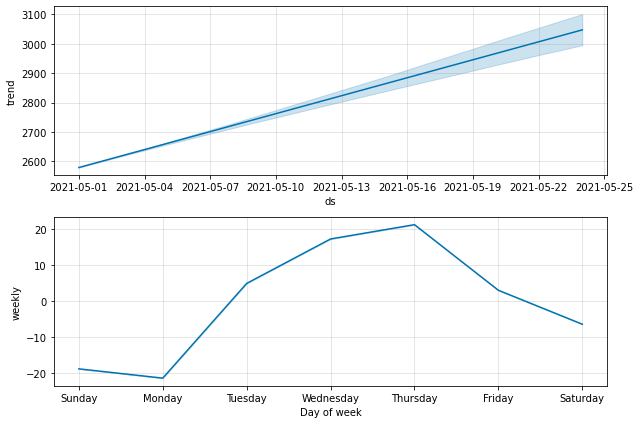

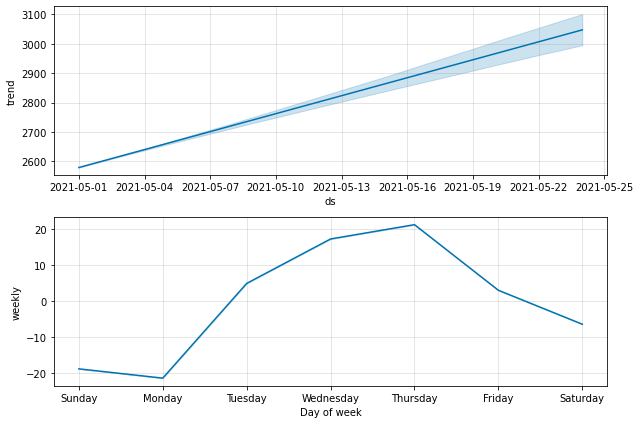

In [58]:
model.plot_components(forecast)

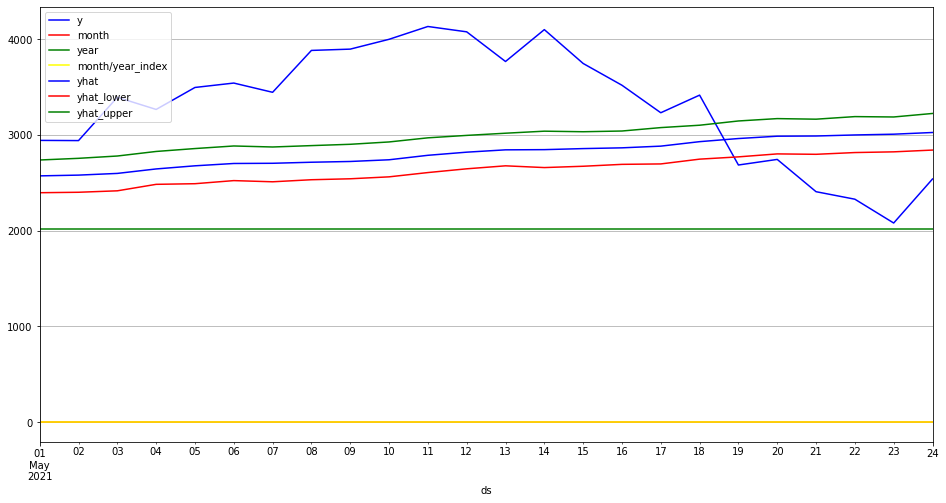

In [60]:
eth_price_forecast = forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]
df = pd.merge(eth_price, eth_price_forecast, on='ds', how='right')
df.set_index('ds').plot(figsize=(16,8), color=['blue', 'red', 'green', 'yellow'], grid=True)

In [62]:
# simulating forecasts
eth_price['dayname'] = eth_price['ds'].dt.day_name()
eth_price['month'] = eth_price['ds'].dt.month
eth_price['year'] = eth_price['ds'].dt.year
eth_price['month/year'] = eth_price['month'].map(str) + '/' + eth_price['year'].map(str) 

eth_price = pd.merge(eth_price, 
                       eth_price['month/year'].drop_duplicates().reset_index(drop=True).reset_index(),
                       on='month/year',
                       how='left')

eth_price = eth_price.rename(columns={'index':'month/year_index'})

eth_price.tail()


,ds,y,dayname,month,year,month/year,month/year_index,month/year_index
139,2021-05-20,"2,744.52",Thursday,5,2021,5/2021,4,4
140,2021-05-21,"2,407.43",Friday,5,2021,5/2021,4,4
141,2021-05-22,"2,329.03",Saturday,5,2021,5/2021,4,4
142,2021-05-23,"2,080.37",Sunday,5,2021,5/2021,4,4
143,2021-05-24,"2,540.00",Monday,5,2021,5/2021,4,4


In [64]:

loop_list = eth_price['month/year'].unique().tolist()
max_num = len(loop_list) - 1
forecast_frames = []

for num, item in enumerate(loop_list):

    if  num == max_num:
        pass
    else:
        df = eth_price.set_index('ds')[
             eth_price[eth_price['month/year'] == loop_list[0]]['ds'].min():\
             eth_price[eth_price['month/year'] == item]['ds'].max()]
        
        df = df.reset_index()[['ds', 'y']]
        
        model = Prophet()
        model.fit(df)
        
        future = eth_price[eth_price['month/year_index'] == (num + 1)][['ds']]

        forecast = model.predict(future)
        forecast_frames.append(forecast)

eth_price_forecast = reduce(lambda top, bottom: pd.concat([top, bottom], sort=False), forecast_frames)
eth_price_forecast = eth_price_forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]
# eth_price_forecast.to_csv('eth_price_forecast.csv', index=False)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations. Using 23.


ValueError: cannot reindex from a duplicate axis

In [59]:
eth_price_forecast.to_csv('../eth_price_forecast.csv', index=False)

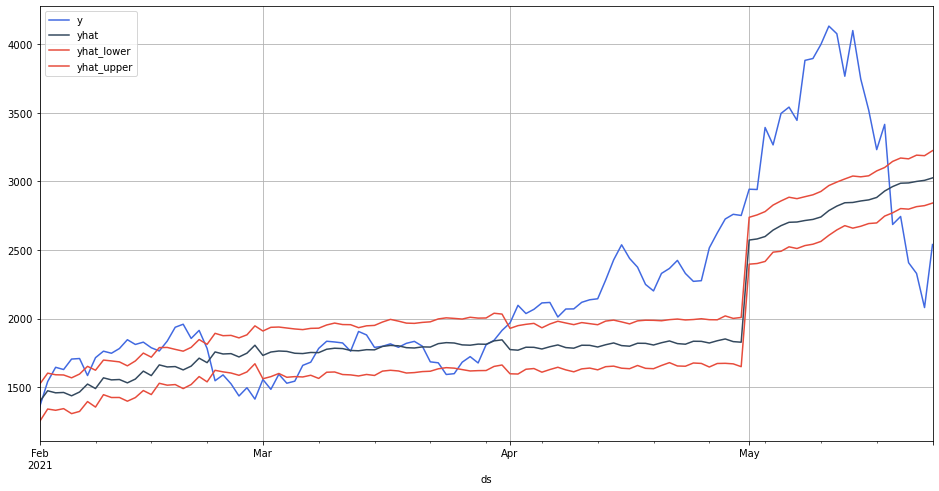

In [61]:
eth_price_forecast = pd.read_csv('../eth_price_forecast.csv', parse_dates=['ds'])

df = pd.merge(eth_price[['ds','y', 'month/year_index']], eth_price_forecast, on='ds')
df['Percent Change'] = df['y'].pct_change()
df.set_index('ds')[['y', 'yhat', 'yhat_lower', 'yhat_upper']].plot(figsize=(16,8), color=['royalblue', "#34495e", "#e74c3c", "#e74c3c"], grid=True)

In [63]:
# trading algo
df['Hold'] = (df['Percent Change'] + 1).cumprod()
df['Prophet'] = ((df['yhat'].shift(-1) > df['yhat']).shift(1) * (df['Percent Change']) + 1).cumprod()
df['Prophet Thresh']  = ((df['y'] > df['yhat_lower']).shift(1)* (df['Percent Change']) + 1).cumprod()
df['Seasonality'] = ((~df['ds'].dt.month.isin([8,9])).shift(1) * (df['Percent Change']) + 1).cumprod()

In [ ]:

df['Hold'] = (df['Percent Change'] + 1).cumprod()
df['Prophet'] = ((df['yhat'].shift(-1) > df['yhat']).shift(1) * (df['Percent Change']) + 1).cumprod()
df['Prophet Thresh']  = ((df['y'] > df['yhat_lower']).shift(1)* (df['Percent Change']) + 1).cumprod()
# sell in may buy in september
df['Seasonality'] = ((~df['ds'].dt.month.isin([5,9])).shift(1) * (df['Percent Change']) + 1).cumprod()

Hold = 13,897
Prophet = 5,550
Prophet Thresh = 13,636
Seasonality = 18,668


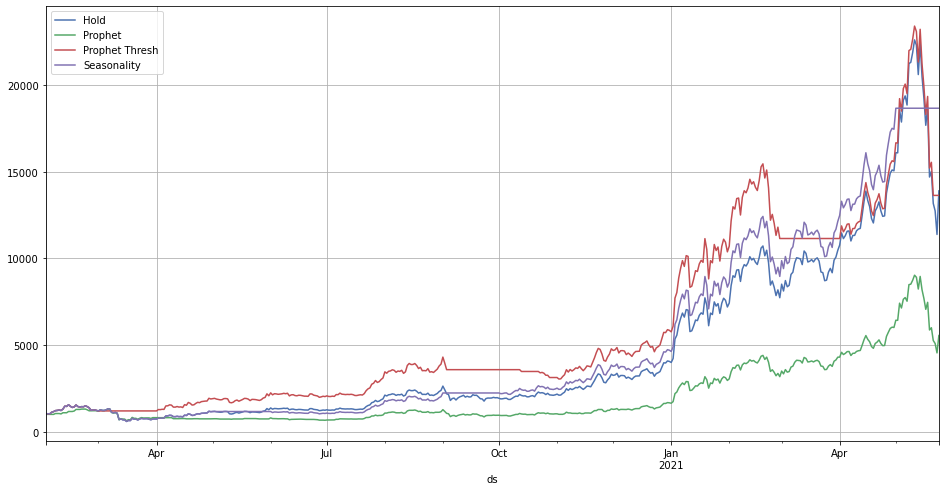

In [26]:
(df.dropna().set_index('ds')[['Hold', 'Prophet', 'Prophet Thresh','Seasonality']] * 1000).plot(figsize=(16,8), grid=True)

print(f"Hold = {df['Hold'].iloc[-1]*1000:,.0f}")
print(f"Prophet = {df['Prophet'].iloc[-1]*1000:,.0f}")
print(f"Prophet Thresh = {df['Prophet Thresh'].iloc[-1]*1000:,.0f}")
print(f"Seasonality = {df['Seasonality'].iloc[-1]*1000:,.0f}")

'Best Yhat = 0.92'

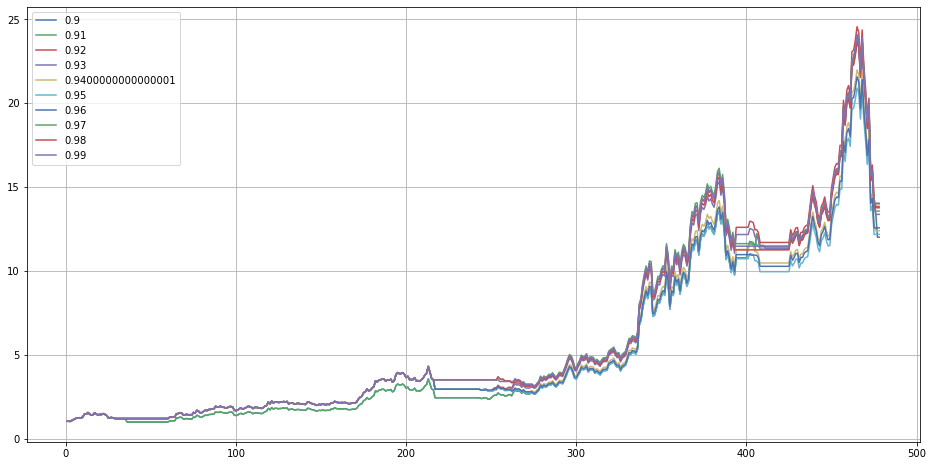

In [28]:
# tuning the threshold for better performance on prophet models
performance = {}

for x in np.linspace(.9,.99,10):
    y = ((df['y'] > df['yhat_lower']*x).shift(1)* (df['Percent Change']) + 1).cumprod()
    performance[x] = y
    
best_yhat = pd.DataFrame(performance).max().idxmax()
pd.DataFrame(performance).plot(figsize=(16,8), grid=True);
f'Best Yhat = {best_yhat:,.2f}'

In [29]:

df['Optimized Prophet Thresh']  = ((df['y'] > df['yhat_lower'] * best_yhat).shift(1) * 
                                   (df['Percent Change']) + 1).cumprod()

Hold = 13,897
Prophet = 5,550
Prophet Thresh = 13,636
Seasonality = 18,668
Optimized Prophet Thresh = 13,839


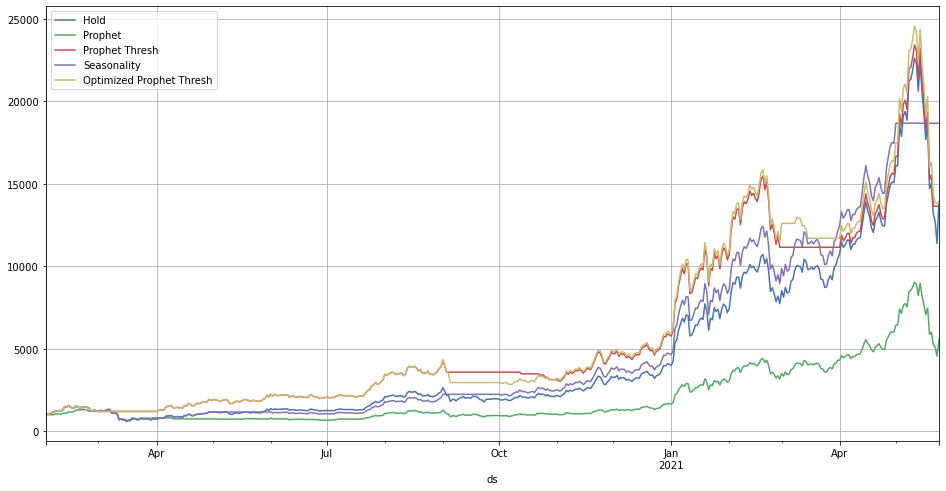

In [30]:
(df.dropna().set_index('ds')[['Hold', 'Prophet', 'Prophet Thresh',
                              'Seasonality', 'Optimized Prophet Thresh']] * 1000).plot(figsize=(16,8), grid=True)

print(f"Hold = {df['Hold'].iloc[-1]*1000:,.0f}")
print(f"Prophet = {df['Prophet'].iloc[-1]*1000:,.0f}")
print(f"Prophet Thresh = {df['Prophet Thresh'].iloc[-1]*1000:,.0f}")
print(f"Seasonality = {df['Seasonality'].iloc[-1]*1000:,.0f}")
print(f"Optimized Prophet Thresh = {df['Optimized Prophet Thresh'].iloc[-1]*1000:,.0f}")

In [31]:
fcst_thresh = {}

for num, index in enumerate(df['month/year_index'].unique()):

    temp_df = df.set_index('ds')[
         df[df['month/year_index'] == df['month/year_index'].unique()[0]]['ds'].min():\
         df[df['month/year_index'] == index]['ds'].max()]

    performance = {}
    
    for thresh in np.linspace(0, .99, 100):
        percent =  ((temp_df['y'] > temp_df['yhat_lower'] * thresh).shift(1)* (temp_df['Percent Change']) + 1).cumprod()
        performance[thresh] = percent
    
    best_thresh = pd.DataFrame(performance).max().idxmax()
    
    if num == len(df['month/year_index'].unique())-1:
        pass
    else:
        fcst_thresh[df['month/year_index'].unique()[num+1]] = best_thresh

In [32]:
fcst_thresh = pd.DataFrame([fcst_thresh]).T.reset_index().rename(columns={'index':'month/year_index', 0:'Fcst Thresh'})

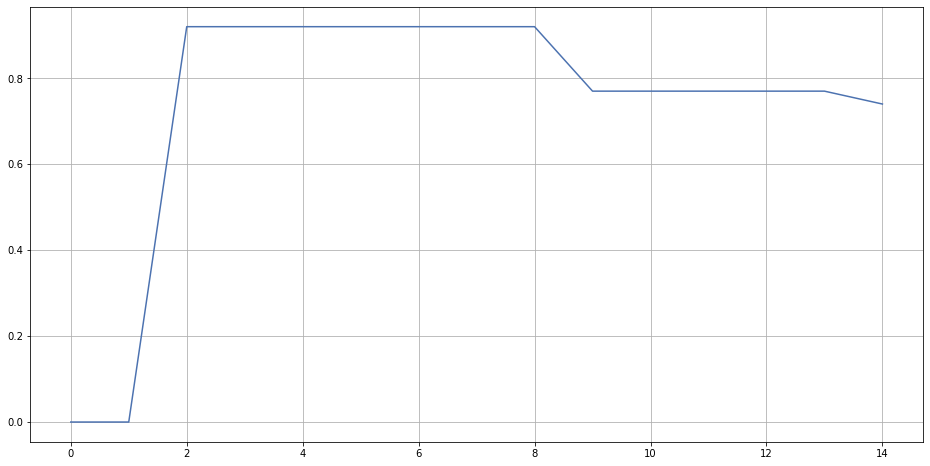

In [33]:
fcst_thresh['Fcst Thresh'].plot(figsize=(16,8), grid=True);


In [34]:
df['yhat_optimized'] = pd.merge(df, fcst_thresh, 
                                on='month/year_index', 
                                how='left')['Fcst Thresh'].shift(1) * df['yhat_lower']

In [35]:
df['Prophet Fcst Thresh']  = ((df['y'] > df['yhat_optimized']).shift(1)* (df['Percent Change']) + 1).cumprod()

Hold = 13,897
Prophet = 5,550
Prophet Thresh = 13,636
Prophet Fcst Thresh = 9,417


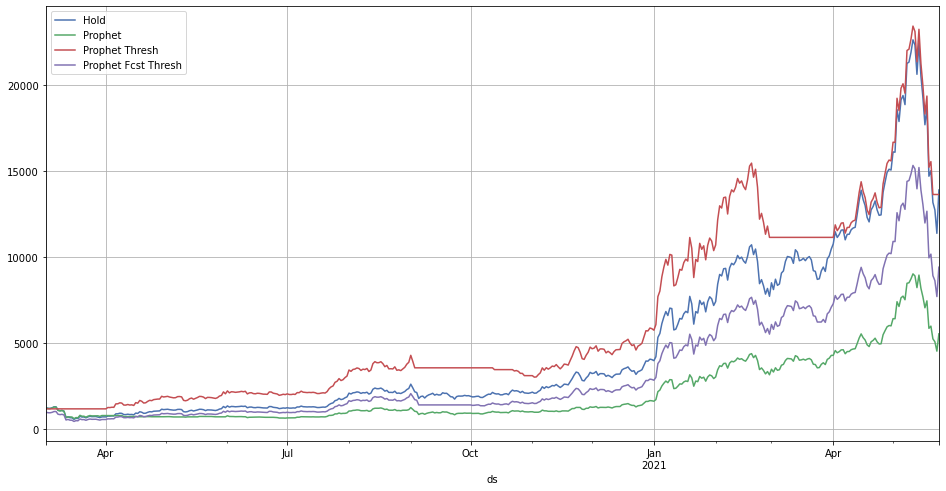

In [36]:

(df.dropna().set_index('ds')[['Hold', 'Prophet', 'Prophet Thresh',
                              'Prophet Fcst Thresh']] * 1000).plot(figsize=(16,8), grid=True)

print(f"Hold = {df['Hold'].iloc[-1]*1000:,.0f}")
print(f"Prophet = {df['Prophet'].iloc[-1]*1000:,.0f}")
print(f"Prophet Thresh = {df['Prophet Thresh'].iloc[-1]*1000:,.0f}")
# print(f"Seasonality = {df['Seasonality'].iloc[-1]*1000:,.0f}")
print(f"Prophet Fcst Thresh = {df['Prophet Fcst Thresh'].iloc[-1]*1000:,.0f}")

In [37]:
rolling_thresh = {}

for num, index in enumerate(df['month/year_index'].unique()):
  
    rolling_performance = {}
    
    for roll in range(10, 400, 10):
            
        temp_df = df.set_index('ds')[
             df[df['month/year_index'] == index]['ds'].min() - pd.DateOffset(months=roll):\
             df[df['month/year_index'] == index]['ds'].max()]

        performance = {}
        
        for thresh in np.linspace(.0,.99, 100):
            percent =  ((temp_df['y'] > temp_df['yhat_lower'] * thresh).shift(1)* (temp_df['Percent Change']) + 1).cumprod()
            performance[thresh] = percent

        per_df =  pd.DataFrame(performance)
        best_thresh = per_df.iloc[[-1]].max().idxmax()
        percents = per_df[best_thresh]
        
        rolling_performance[best_thresh] = percents
    
    per_df =  pd.DataFrame(rolling_performance)
    best_rolling_thresh = per_df.iloc[[-1]].max().idxmax()
    
    if num == len(df['month/year_index'].unique())-1:
        pass
    else:
        rolling_thresh[df['month/year_index'].unique()[num+1]] = best_rolling_thresh

In [38]:
rolling_thresh = pd.DataFrame([rolling_thresh]).T.reset_index().rename(columns={'index':'month/year_index', 0:'Fcst Thresh'})

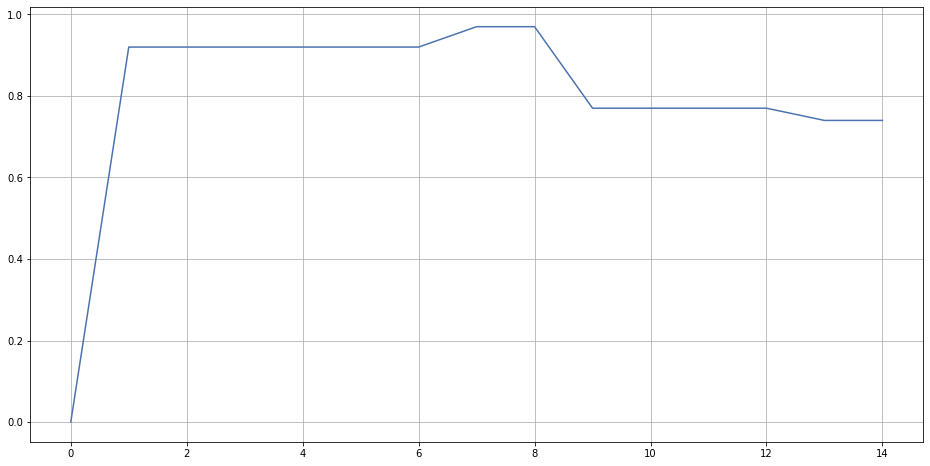

In [39]:
rolling_thresh['Fcst Thresh'].plot(figsize=(16,8), grid=True);


In [40]:
df['yhat_optimized'] = pd.merge(df, rolling_thresh, 
                                on='month/year_index', 
                                how='left')['Fcst Thresh'].fillna(1).shift(1) * df['yhat_lower']

In [41]:

df['Prophet Rolling Thresh']  = ((df['y'] > df['yhat_optimized']).shift(1)* (df['Percent Change']) + 1).cumprod()

Hold = 13,897
Prophet = 5,550
Prophet Thresh = 13,636
Prophet Fcst Thresh = 9,417
Prophet Rolling Thresh = 9,114


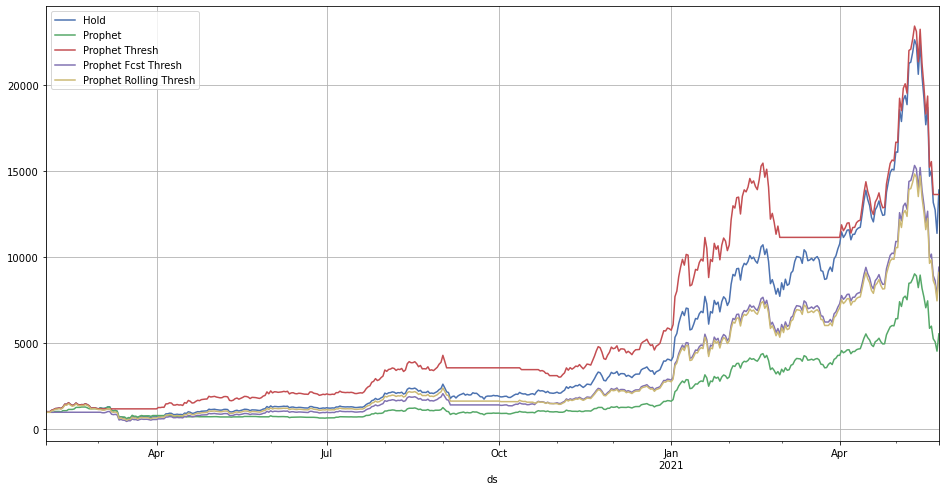

In [42]:
(df.dropna().set_index('ds')[['Hold', 'Prophet', 'Prophet Thresh',
                              'Prophet Fcst Thresh', 'Prophet Rolling Thresh']] * 1000).plot(figsize=(16,8), grid=True)

print(f"Hold = {df['Hold'].iloc[-1]*1000:,.0f}")
print(f"Prophet = {df['Prophet'].iloc[-1]*1000:,.0f}")
print(f"Prophet Thresh = {df['Prophet Thresh'].iloc[-1]*1000:,.0f}")
# print(f"Seasonality = {df['Seasonality'].iloc[-1]*1000:,.0f}")
print(f"Prophet Fcst Thresh = {df['Prophet Fcst Thresh'].iloc[-1]*1000:,.0f}")
print(f"Prophet Rolling Thresh = {df['Prophet Rolling Thresh'].iloc[-1]*1000:,.0f}")